This example comprises the application of a convolutional Autoencoder (AE) to a two-dimensional Rayleigh-Bénard convection (RBC) flow. 

---

### 1. Data Specifications 

The flow data was obtained by means of a direct numerical simulation (DNS) using the spectral element solver Nek5000 (https://github.com/Nek5000/Nek5000).

The data comprises the horizontal and vertical velocity fields $(u_x(x,y),u_z(x,y))^T$ as well as the temperature field $T(x,y)$. 

The RBC flow parameters were 
- Prandtl number $Pr = 10$
- Rayleigh number $Ra = 10^6$
- aspect ratio of the spatial domain: $\Gamma = L_x/H = 4$

The boundary conditions were:
- free slip for the horizontal velocity
- no-penetration for the vertical velocity
- constant temperature (Dirichlet)

The DNS fields are interpolated to a uniform grid of size $N_x \times N_y = 128 \times 32$. The total number of snapshots was $N_t = 10^4$. Their spacing is $0.25$ free fall times $H/U_f$.

Let's import the data and inspect it:

In [1]:
import numpy as np

data = np.load("data/RBC_A4Ra1e6Pr10_fs.npy")
nt, nfields, ny, nx = data.shape

Text(0.5, 1.0, '$T(x,y)$')

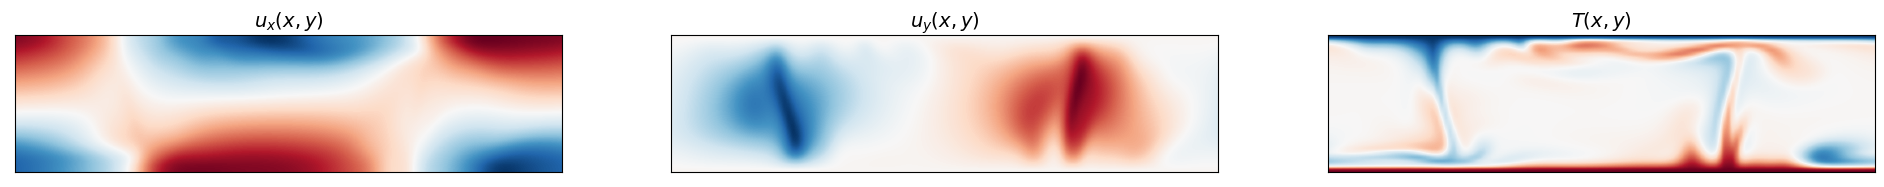

In [2]:
import matplotlib.pyplot as plt

it = 0  # which snapshot to show

fig,axs = plt.subplots(figsize=(8*3,2),ncols=3,nrows=1)
for ii,ifield in enumerate(range(nfields)):
    axs[ii].imshow(np.flip(data[it,ifield],axis=0),cmap="RdBu_r",interpolation="gaussian")
    
for iax in axs:
    iax.set_xticks([])
    iax.set_yticks([])
axs[0].set_title(r"$u_x(x,y)$",fontsize=14)
axs[1].set_title(r"$u_y(x,y)$",fontsize=14)
axs[2].set_title(r"$T(x,y)$",fontsize=14)

The AE will receive a single input comprising an instantenous snapshot of these three fields. The Encoder part will then compress the snapshot of size `(3,32,128)` to the user-specified encoding dimension $N_{AE}$, e.g. $N_{AE}=16$ (default value here).

---

### 2. Neural Network (NN) specifications

The NN is implemented using the PyTorch framework (https://pytorch.org/get-started). The NN is specified in the `nn.py` file, where it can be adapted to the desired AE architecture. We can inspect the NN architecture via the torchsummary module (https://github.com/sksq96/pytorch-summary).

In [3]:
import torch
import torch.nn as nn
from torchsummary import summary
from nn import Autoencoder   #import custome AE NN

model = Autoencoder()

summary(model, (nfields,ny,nx),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 3, 32, 128]              84
              ReLU-2           [-1, 3, 32, 128]               0
              ReLU-3           [-1, 3, 32, 128]               0
            Conv2d-4           [-1, 4, 32, 128]             112
              ReLU-5           [-1, 4, 32, 128]               0
              ReLU-6           [-1, 4, 32, 128]               0
         MaxPool2d-7            [-1, 4, 32, 64]               0
       BatchNorm2d-8            [-1, 4, 32, 64]               8
              Down-9            [-1, 4, 32, 64]               0
          Dropout-10            [-1, 4, 32, 64]               0
           Conv2d-11            [-1, 4, 32, 64]             148
             ReLU-12            [-1, 4, 32, 64]               0
             ReLU-13            [-1, 4, 32, 64]               0
           Conv2d-14            [-1, 8,

---

### 3. Before training the AE

Before we train the AE, we have to normalize the input data, as it is conventionally done in DeepLearning. Here we normalize each physical field by its maximum and minimum value s.t.

$$\tilde{x} = \frac{x - \underset{\rm training}{\min(x)}}{\underset{\rm training}{\max(x)} - \underset{\rm training}{\min(x)}}$$

These min/max values for $u_x,u_y$ and $T$ are pre-computed and stored in the `RBC_A4Ra1e6Pr10_fs_minmax.hdf5` file for normalization and unnormalization purposes. Note that the max and min is taken over the training period only, to not compromise the validation and test dataset.

In [4]:
import h5py   #pip install h5py
trainingLength = 8000
validationLength = 1000

# compute min/max values of each field
#------------------------------------------
if False:  # already computed
    x_min = data[:trainingLength].min(axis=(0,2,3))
    x_max = data[:trainingLength].max(axis=(0,2,3))

    # save to a hdf5 file
    with h5py.File("data/RBC_A4Ra1e6Pr10_fs_minmax.hdf5","a") as f:
        f.create_dataset("min",data=x_min)
        f.create_dataset("max",data=x_max)

    
# Read saved min/max values
#----------------------------
with h5py.File("data/RBC_A4Ra1e6Pr10_fs_minmax.hdf5","r") as f:
    print(f.keys())
    x_min = torch.from_numpy(np.array(f["min"])).reshape(nfields,1,1)
    x_max = torch.from_numpy(np.array(f["max"])).reshape(nfields,1,1)

<KeysViewHDF5 ['max', 'min']>


As is done in PyTorch, the data is processes via a Dataloader, which requires a user-specified Dataset. This Dataset is specified in `dataset.py`. We will have to set up one for each of the three cross-validation phases (training, validation, testing). Here, the Dataset is constructed in a way, s.t. the RBC data is imported at its initialization and each snapshot is handed out for the specified time instance. Moreover, the handed out snapshot will be min-max normalized if we specify a correct transform.

In [5]:
from torch.utils.data import DataLoader
from torchvision.transforms import Lambda
from dataset import RBC2dDataset  # import custome Dataset

transform_minmax = Lambda(lambda x:(x - x_min)/(x_max - x_min))
    
dataset_train = RBC2dDataset(filepath="data/RBC_A4Ra1e6Pr10_fs.npy", 
                             tstart=0, 
                             tend=trainingLength, 
                             transform=transform_minmax)

dataset_val = RBC2dDataset(filepath="data/RBC_A4Ra1e6Pr10_fs.npy", 
                             tstart=trainingLength, 
                             tend=trainingLength+validationLength, 
                             transform=transform_minmax)


# Create Dataloader for batch-wise input
#----------------------------------------
dataloader_train = DataLoader(dataset_train,
                              batch_size=64,
                              shuffle=True,
                              drop_last=True)

dataloader_val = DataLoader(dataset_val,
                              batch_size=64,
                              shuffle=True,
                              drop_last=True)

---

### 4. Training & Validation

For training, we have to specify a training loss function as well as the optimization routine:

In [6]:
learning_rate = 1e-3

mse  = nn.MSELoss()
loss = nn.MSELoss() # adapt to desired loss function
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=1e-6)

Then we can proceed to train the model with the RBC data by iterating over the Dataloader. In each epoch we can evaluate the AE performance on the validation dataset by using its corresponding Dataloader.

In [7]:
import random
num_epochs = 40
n_epoch_stop = 5  #early stopping: after how many epochs of no improvement to seize training


# Set random seed
#-------------------
randomSeed = 43
torch.manual_seed(randomSeed)
torch.cuda.manual_seed_all(randomSeed)
np.random.seed(randomSeed)
random.seed(randomSeed)


# Init lists for loss-tracking
#--------------------------------
loss_train_list, mse_train_list = [], []
loss_val_list, mse_val_list = [], []
min_val_loss = torch.tensor(float("inf"))

epochs_no_improve = 0
optimizer.zero_grad()
num_epochs_run = 0
for epoch in range(num_epochs):

    # ------------------
    # 4.1 Training
    # ------------------
    train_mse = 0.0
    train_loss = 0.0

    model.train()
    for i, data_train in enumerate(dataloader_train):
        optimizer.zero_grad()
        outputs, _ = model(data_train)

        mse_train = mse(outputs, data_train)
        loss_train = loss(outputs, data_train)

        loss_train.backward()
        optimizer.step()
        train_mse  += mse_train.item()
        train_loss += loss_train.item()

    mse_train_list.append(train_mse/len(dataloader_train))
    loss_train_list.append(train_loss/len(dataloader_train))

    # ------------------
    # 4.2 Validation
    # ------------------
    val_mse = 0.0
    val_loss = 0.0

    model.eval()
    with torch.no_grad():
        for i, data_val in enumerate(dataloader_val):
            outputs_val, _ = model(data_val)

            mse_val = mse(outputs_val, data_val)
            loss_val = loss(outputs_val, data_val)

            val_mse += mse_val.item()
            val_loss += loss_val.item()

    mse_val_list.append(val_mse / len(dataloader_val))
    loss_val_list.append(val_loss / len(dataloader_val))

    print('Epoch {0}/{1}, Train MSE {2:.2e}, Validation MSE {3:.2e}, Train Loss {4:.2e}, Validation Loss {5:.2e}'.format(epoch+1, 
                                                                                                                         num_epochs, 
                                                                                                                         train_mse/len(dataloader_train), 
                                                                                                                         val_mse/len(dataloader_val), 
                                                                                                                         train_loss/len(dataloader_train), 
                                                                                                                         val_loss/len(dataloader_val)))

    # -----------------------------
    # Early stopping & Save weights
    # -----------------------------
    num_epochs_run +=1
    
    if epoch > 5 and epochs_no_improve == n_epoch_stop:
        print("Early stopping after {0} epochs of no improvement".format(n_epoch_stop))
        break
        
    
    if val_loss < min_val_loss:
        #ae.save_model_checkpoint(deepcopy(model))
        epochs_no_improve = 0
        min_val_loss = val_loss
    else:
        epochs_no_improve += 1


Epoch 1/40, Train MSE 1.81e-02, Validation MSE 1.32e-02, Train Loss 1.81e-02, Validation Loss 1.32e-02
Epoch 2/40, Train MSE 1.03e-02, Validation MSE 7.85e-03, Train Loss 1.03e-02, Validation Loss 7.85e-03
Epoch 3/40, Train MSE 8.25e-03, Validation MSE 6.49e-03, Train Loss 8.25e-03, Validation Loss 6.49e-03
Epoch 4/40, Train MSE 7.28e-03, Validation MSE 6.12e-03, Train Loss 7.28e-03, Validation Loss 6.12e-03
Epoch 5/40, Train MSE 6.74e-03, Validation MSE 5.87e-03, Train Loss 6.74e-03, Validation Loss 5.87e-03
Epoch 6/40, Train MSE 6.49e-03, Validation MSE 5.84e-03, Train Loss 6.49e-03, Validation Loss 5.84e-03
Epoch 7/40, Train MSE 6.32e-03, Validation MSE 5.72e-03, Train Loss 6.32e-03, Validation Loss 5.72e-03
Epoch 8/40, Train MSE 6.19e-03, Validation MSE 5.76e-03, Train Loss 6.19e-03, Validation Loss 5.76e-03
Epoch 9/40, Train MSE 6.06e-03, Validation MSE 5.47e-03, Train Loss 6.06e-03, Validation Loss 5.47e-03
Epoch 10/40, Train MSE 5.95e-03, Validation MSE 5.39e-03, Train Loss 5.95

Let's see how the training performed over the course of the epochs

(1.0, 10.0)

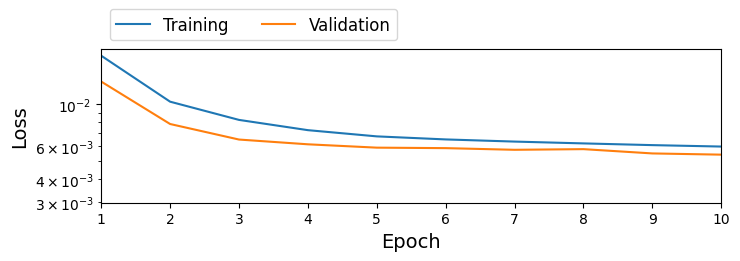

In [8]:
fig,axs = plt.subplots(figsize=(8,2))
axs.semilogy(range(1,num_epochs_run+1),loss_train_list,label="Training")
axs.semilogy(range(1,num_epochs_run+1),loss_val_list,label="Validation")

axs.legend(fontsize=12,ncols=2,loc="lower left",bbox_to_anchor=(0,1))
axs.set_xlabel("Epoch",fontsize=14)
axs.set_ylabel("Loss",fontsize=14)
axs.set_xlim([1,10])

---

### 5. Inspect Encoder

Moreover, we can compute the reduced representation of the RBC data by running only the encoder

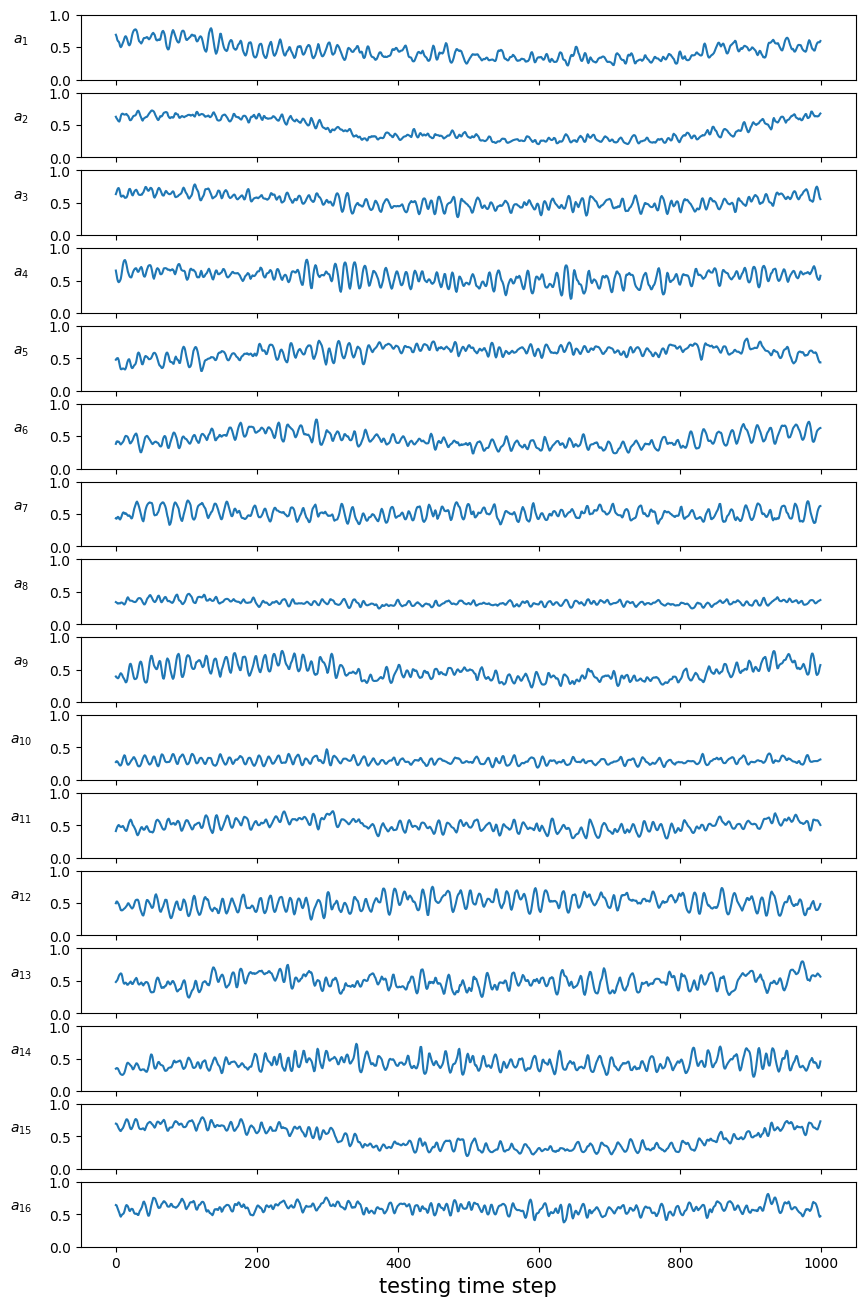

In [9]:
# Get normalized testing data
#------------------------------
data_test = transform_minmax(torch.from_numpy(data[9000:]))  

# Run Encoder
#-------------
encoded = model.encoder(data_test)
encoded = encoded.detach()

# Plot Encoder output over time
#--------------------------------
fig,axs = plt.subplots(figsize=(10,model.encoding_dim//2*1),nrows=model.encoding_dim//2,sharex=True)

for ii,imode in enumerate(range(model.encoding_dim//2)):
    axs[ii].plot(encoded[:,imode])
    axs[ii].set_ylabel(r"$a_{"+f"{imode+1}"+r"}$",rotation=0,labelpad=20)
    
axs[-1].set_xlabel("testing time step",fontsize=15)
for iax in axs:
    iax.set_ylim([0,1])

---

### 6. Inspect the Decoder

From these, we can reconstruct the physical fields, reverse the normalization and inspect how the Decoder part performs.

In [10]:
transform_minmax_undo = Lambda(lambda x: x*(x_max-x_min)+x_min)  #reverse min-max normalization

data_test_decoder = model.decoder(encoded)
data_test_decoder = data_test_decoder.detach()
data_test_decoder = transform_minmax_undo(data_test_decoder)

Text(0.5, 1.0, '$T(x,y)$')

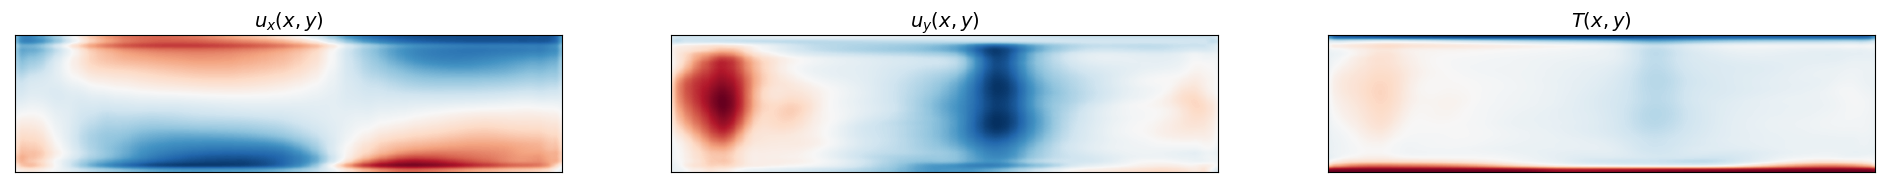

In [11]:
import matplotlib.pyplot as plt

it = 0  # which snapshot in the testing phase to show

fig,axs = plt.subplots(figsize=(8*3,2),ncols=3,nrows=1)
for ii,ifield in enumerate(range(nfields)):
    axs[ii].imshow(data_test_decoder[it,ifield].flip(0),cmap="RdBu_r",interpolation="gaussian")
    
for iax in axs:
    iax.set_xticks([])
    iax.set_yticks([])
axs[0].set_title(r"$u_x(x,y)$",fontsize=14)
axs[1].set_title(r"$u_y(x,y)$",fontsize=14)
axs[2].set_title(r"$T(x,y)$",fontsize=14)

Now these result can readily be improved by adapting the AE's hyperparameters (no. epochs, learning rate, batch size, etc.). As you can see the training on the CPU quickly becomes computationally intensive. Therefore, one should switch to a GPU device. Luckily, PyTorch makes the transition from CPU to GPU extremely easy. See below.

---

### 7. Switching to GPU 

The AE can get quite big as its number of parameters grows. The training will consequently become quite slow. Hence it is useful to switch from a CPU to a GPU device, which immensly accerlates the training process. For this the `train.py` script is provided. It comprises all the steps shown above for the GPU and saves the trained model to the disc. Keeping track of all the hyperparameters, data and user specification can become quite combersome. This is where the `turbAE` class comes in. It manages the weight saving process and provides a base for all hyperparameter queries. Together with a YAML config file (`train_config.yaml`), where the user enters all hyperaparameter and file path specifications, this class handles all additional tasks.

The `train.py` script already incorporates a turbAE class object. All you have to do to train the AE on the GPU with this script is to enter your AE configuration in the `train_config.yaml` file, which is read by `train.py`. 

After that just run 

`python -u train.py`

and observe the output. 

Check it out!

---



-Florian Heyder 13.10.2023